In [1]:
import os
import sys
# SRC_DIR environment variable should be the absolute path to the 'multicopy-STR-genotyping' directory
sys.path.append(os.environ["SRC_DIR"])

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from multicopy_STR_genotyping import file_io

sns.set_context("poster")
%matplotlib inline

In [3]:
vcf = "../../../data/HG002/variants/ConSTRain/v.0.8.2/HG002.GRCh38.2x250_depth30x_with_mononuc.vcf" # str: path to input vcf file                      
vcf_format = "ConSTRain" # str: which tool was used to genotype
sample = "HG002.GRCh38.2x250_depth30x" # str: name of sample in vcf to analyse
set_cn = False # bool: set CN of loci manually (based on chromosome name)
gt_in_bp = False # bool: does the tool report genotypes in bp (True) or in number of repeat units (False)
strs_covered_by_haplotypes = "../../../data/HG002/regions/hg38_ver13_0boe_mononucleotides_union.bed" # str: path to bed with loci that are covered by the haplotypes provided by Q100
haplotype_str_length = "../../../data/HG002/variants/HG002_GRCh38_STR_lengths.csv" # str: path to csv with STR allele lengths based on Q100 haplotypes
comparison_file_out = None # None or str: path to write csv with comparison of STR allele lengths from vcf to Q100 STR allele lengths

depth_filter = 0.05 # None or float. Alpha to use for filtering loci with extreme depth values
filt_segdup = True

In [4]:
def set_cn_manually(df):
    autosomes = [f"chr{i}" for i in range(1, 23)]
    df = df.assign(
        copy_number = lambda x: [2 if i in autosomes else 1 for i in x["chr"]]
    )
    return df

In [5]:
df_repeats, df_hg002 = file_io.dfs_from_vcf(filename=vcf, samples=[sample], vcf_format=vcf_format)
df_hg002 = df_hg002.dropna().assign(
    depth = lambda x: [sum(i.values()) for i in x["frequencies"]],
    depth_norm = lambda x: x["depth"] / x["copy_number"]
).reset_index(drop=True)
df_hg002 = df_hg002.merge(df_repeats[["str_id", "period"]], on="str_id", how="left")
print(df_repeats.shape, df_hg002.shape)


(1733646, 7) (1657944, 8)


In [6]:
if depth_filter:
    print(df_hg002.shape)
    # lower should be at least 1 for diploid organism I guess...
    lower = max(1, df_hg002.query("period > 1")["depth_norm"].quantile(q=depth_filter/2))
    upper = df_hg002.query("period > 1")["depth_norm"].quantile(q=1-(depth_filter/2))
    print(lower, upper)
    df_hg002 = df_hg002.query(f"depth_norm >= {lower} and depth_norm <= {upper}").reset_index(drop=True)
    print(df_hg002.shape)


(1657944, 8)
3.0 15.5
(1484479, 8)


In [7]:
df_covered_repeats = pd.read_csv(strs_covered_by_haplotypes, sep="\t", names=["chr", "start", "end", "period", "unit"])
df_covered_repeats = df_covered_repeats.assign(
            str_id = np.array([f"{chrom}_{start + 1}" for chrom, start in zip(df_covered_repeats.chr, df_covered_repeats.start)])
)

df_covered_repeats = df_repeats[df_repeats["str_id"].isin(df_covered_repeats["str_id"])]

df_hg002 = df_hg002.merge(
    df_covered_repeats[["str_id", "chr", "start", "end", "unit", "ref"]], on="str_id", how="inner"
)

if set_cn:
    df_hg002 = set_cn_manually(df_hg002)
    
df_hg002 = df_hg002.dropna().reset_index(drop=True)

print(df_covered_repeats.shape, df_hg002.shape)

df_hg002


(1695865, 7) (1465601, 13)


,sample,str_id,copy_number,frequencies,genotype,depth,depth_norm,period,chr,start,end,unit,ref
0,HG002.GRCh38.2x250_depth30x,chr1_588068,2,{4: 8},"[4, 4]",8,4.0,3,chr1,588068,588079,CCT,4
1,HG002.GRCh38.2x250_depth30x,chr1_590659,2,{3: 16},"[3, 3]",16,8.0,4,chr1,590659,590670,AAAT,3
2,HG002.GRCh38.2x250_depth30x,chr1_590969,2,{4: 10},"[4, 4]",10,5.0,4,chr1,590969,590984,AAAC,4
3,HG002.GRCh38.2x250_depth30x,chr1_594083,2,{4: 7},"[4, 4]",7,3.5,3,chr1,594083,594094,TCC,4
4,HG002.GRCh38.2x250_depth30x,chr1_598935,2,{11: 9},"[11, 11]",9,4.5,1,chr1,598935,598945,G,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465596,HG002.GRCh38.2x250_depth30x,chrY_26620291,1,{17: 3},[17],3,3.0,1,chrY,26620291,26620307,A,17
1465597,HG002.GRCh38.2x250_depth30x,chrY_26622472,1,{2: 13},[2],13,13.0,5,chrY,26622472,26622481,AAATA,2
1465598,HG002.GRCh38.2x250_depth30x,chrY_26627699,1,{4: 7},[4],7,7.0,3,chrY,26627699,26627710,GAA,4
1465599,HG002.GRCh38.2x250_depth30x,chrY_26635262,1,{10: 7},[10],7,7.0,1,chrY,26635262,26635271,A,10


In [8]:
if filt_segdup:
    df_in_segdup = pd.read_csv("../../../data/hg38_ver13_0boe_mononucleotides_in_segdup.bed", sep="\t", names=["chr", "start", "end", "period", "unit"])
    df_in_segdup = df_in_segdup.assign(str_id = lambda x: [f"{i}_{j + 1}" for i, j in zip(x["chr"], x["start"])])
    
    df_hg002 = df_hg002[~df_hg002["str_id"].isin(df_in_segdup["str_id"])].reset_index(drop=True)
    print(df_hg002.shape)

(1410235, 13)


In [9]:
df_hg002.shape[0] / df_covered_repeats.shape[0] * 100

83.15726782497428

In [10]:
if gt_in_bp:
    df_hg002 = df_hg002.assign(
        illumina_region_len = lambda x: [sorted(gt) for gt in x["genotype"]],
        depth = lambda x: [sum(i.values()) for i in x["frequencies"]],
    )
else:
    df_hg002 = df_hg002.assign(
        illumina_region_len = lambda x: [sorted([k * j for k in i]) for i, j in zip(x["genotype"], x["period"])],
        depth = lambda x: [sum(i.values()) for i in x["frequencies"]],
    )
    
df_hg002

,sample,str_id,copy_number,frequencies,genotype,depth,depth_norm,period,chr,start,end,unit,ref,illumina_region_len
0,HG002.GRCh38.2x250_depth30x,chr1_902774,2,"{14: 12, 15: 1}","[14, 14]",13,6.5,1,chr1,902774,902788,A,15,"[14, 14]"
1,HG002.GRCh38.2x250_depth30x,chr1_904440,2,{3: 20},"[3, 3]",20,10.0,3,chr1,904440,904448,CTC,3,"[9, 9]"
2,HG002.GRCh38.2x250_depth30x,chr1_904654,2,{4: 15},"[4, 4]",15,7.5,3,chr1,904654,904665,CCT,4,"[12, 12]"
3,HG002.GRCh38.2x250_depth30x,chr1_907237,2,{14: 24},"[14, 14]",24,12.0,1,chr1,907237,907250,A,14,"[14, 14]"
4,HG002.GRCh38.2x250_depth30x,chr1_914949,2,{16: 19},"[16, 16]",19,9.5,1,chr1,914949,914964,A,16,"[16, 16]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1410230,HG002.GRCh38.2x250_depth30x,chrY_26487819,1,{10: 7},[10],7,7.0,1,chrY,26487819,26487828,A,10,[10]
1410231,HG002.GRCh38.2x250_depth30x,chrY_26487987,1,{10: 12},[10],12,12.0,1,chrY,26487987,26487996,A,10,[10]
1410232,HG002.GRCh38.2x250_depth30x,chrY_26489202,1,{3: 14},[3],14,14.0,4,chrY,26489202,26489213,TAAA,3,[12]
1410233,HG002.GRCh38.2x250_depth30x,chrY_26489935,1,{4: 4},[4],4,4.0,3,chrY,26489935,26489946,AGA,4,[12]


In [11]:
df_strs_haplotypes = pd.read_csv(haplotype_str_length).assign(chr = lambda x: [i[0] for i in x["str_id"].str.split("_")])
df_strs_haplotypes

,str_id,region_len_ref,region_len_mat,region_len_pat,chr
0,chr1_588068,12,12.0,12.0,chr1
1,chr1_589245,12,12.0,12.0,chr1
2,chr1_590659,12,12.0,12.0,chr1
3,chr1_590969,16,16.0,16.0,chr1
4,chr1_591734,18,20.0,20.0,chr1
...,...,...,...,...,...
1695860,chrY_57188868,11,NaN,11.0,chrY
1695861,chrY_57200838,14,NaN,15.0,chrY
1695862,chrY_57201000,20,NaN,20.0,chrY
1695863,chrY_57202381,23,NaN,23.0,chrY


In [12]:
autosomes = "chr != 'chrX' and chr != 'chrY'"
X = "chr == 'chrX'"
Y = "chr == 'chrY'"

df_strs_haplotypes["haplo_region_len"] = [[] for i in range(len(df_strs_haplotypes))]

df_strs_haplotypes.loc[df_strs_haplotypes.eval(autosomes), "haplo_region_len"] = pd.Series([
    sorted([np.int64(i), np.int64(j)]) for i, j in zip(
        df_strs_haplotypes.loc[df_strs_haplotypes.eval(autosomes), "region_len_mat"], 
        df_strs_haplotypes.loc[df_strs_haplotypes.eval(autosomes), "region_len_pat"],)])

for i, j in zip(
        df_strs_haplotypes.loc[df_strs_haplotypes.eval(X), "haplo_region_len"],
        df_strs_haplotypes.loc[df_strs_haplotypes.eval(X), "region_len_mat"]):
    i.append(np.int64(j))
    
for i, j in zip(
        df_strs_haplotypes.loc[df_strs_haplotypes.eval(Y), "haplo_region_len"],
        df_strs_haplotypes.loc[df_strs_haplotypes.eval(Y), "region_len_pat"]):
    i.append(np.int64(j))
    
df_strs_haplotypes

,str_id,region_len_ref,region_len_mat,region_len_pat,chr,haplo_region_len
0,chr1_588068,12,12.0,12.0,chr1,"[12, 12]"
1,chr1_589245,12,12.0,12.0,chr1,"[12, 12]"
2,chr1_590659,12,12.0,12.0,chr1,"[12, 12]"
3,chr1_590969,16,16.0,16.0,chr1,"[16, 16]"
4,chr1_591734,18,20.0,20.0,chr1,"[20, 20]"
...,...,...,...,...,...,...
1695860,chrY_57188868,11,NaN,11.0,chrY,[11]
1695861,chrY_57200838,14,NaN,15.0,chrY,[15]
1695862,chrY_57201000,20,NaN,20.0,chrY,[20]
1695863,chrY_57202381,23,NaN,23.0,chrY,[23]


In [13]:
df_comparison = (
    df_strs_haplotypes[["str_id", "haplo_region_len"]]
        .merge(df_hg002[["str_id", "illumina_region_len", "depth", "copy_number", "period"]], on="str_id", how="inner")
        .assign(
            match = lambda x: x["haplo_region_len"] == x["illumina_region_len"],
        )
)

df_comparison

,str_id,haplo_region_len,illumina_region_len,depth,copy_number,period,match
0,chr1_902774,"[14, 14]","[14, 14]",13,2,1,True
1,chr1_904440,"[9, 9]","[9, 9]",20,2,3,True
2,chr1_904654,"[12, 12]","[12, 12]",15,2,3,True
3,chr1_907237,"[14, 14]","[14, 14]",24,2,1,True
4,chr1_914949,"[16, 16]","[16, 16]",19,2,1,True
...,...,...,...,...,...,...,...
1410230,chrY_26487819,[10],[10],7,1,1,True
1410231,chrY_26487987,[10],[10],12,1,1,True
1410232,chrY_26489202,[12],[12],14,1,4,True
1410233,chrY_26489935,[12],[12],4,1,3,True


In [14]:
if comparison_file_out:
    df_comparison.to_csv(comparison_file_out, index=False)

In [15]:
n_wrong = df_comparison.loc[~df_comparison["match"]].shape[0]
n_total = df_comparison.shape[0]

print(f"n correct: {n_total - n_wrong}, n wrong: {n_wrong}, n total: {n_total}")
print("Overall accuracy:", (1 - (n_wrong / n_total)) * 100)

df_comparison.loc[~df_comparison["match"]]

n correct: 1363044, n wrong: 47191, n total: 1410235
Overall accuracy: 96.65367828766126


,str_id,haplo_region_len,illumina_region_len,depth,copy_number,period,match
13,chr1_937397,"[9, 11]","[9, 9]",6,2,1,False
59,chr1_1020848,"[13, 14]","[13, 13]",11,2,1,False
61,chr1_1028321,"[14, 15]","[14, 16]",8,2,1,False
62,chr1_1035170,"[12, 12]","[12, 13]",11,2,1,False
218,chr1_1363439,"[13, 13]","[15, 15]",9,2,1,False
...,...,...,...,...,...,...,...
1408651,chrY_15938169,[154],[20],4,1,2,False
1408916,chrY_16734132,[24],[25],4,1,1,False
1409102,chrY_17119440,[23],[24],3,1,1,False
1409607,chrY_19661679,[13],[12],6,1,1,False


In [16]:
df_plot = pd.DataFrame(
    np.concatenate([np.repeat([1, 2, 3, 4, 5, 6], 7).reshape(-1, 1), np.tile([1, 5, 5, 10, 10, 15, 15, 20, 20, 25, 25, 30, 30, 1e6], 6).reshape(-1, 2)], axis=1),
    columns=["period", "depth_lower", "depth_upper"]
)

accuracy = []
n = []
for row in df_plot.to_dict(orient="records"):
    selected_loci = (
        df_comparison
            .assign(depth = lambda x: x["depth"] / x["copy_number"])
            .query(f"depth >= {row['depth_lower']} and depth < {row['depth_upper']} and period == {row['period']}")["str_id"]
    )
    df_comparison_filt = df_comparison.loc[df_comparison["str_id"].isin(selected_loci)]
    current_n = df_comparison_filt.shape[0]
    if current_n == 0:
        n.append(np.nan)
        accuracy.append(np.nan)
    else:
        n.append(current_n)
        accuracy.append((1 - (df_comparison_filt.loc[~df_comparison_filt["match"]].shape[0] / df_comparison_filt.shape[0])) * 100)

df_plot["n"] = n
df_plot["accuracy"] = accuracy
df_plot["depth"] = np.tile(["1-5", "5-10", "10-15", "15-20", "20-25", "25-30", "30-"], 6)

In [17]:
for name, data in df_plot.groupby("depth"):
    print(name, np.average(data["accuracy"], weights=data["n"]), data["n"].sum())
print()
for name, data in df_plot.groupby("period"):
    print(name, np.average(data["accuracy"], weights=data["n"]), data["n"].sum())



1-5 85.41992894836685 144965.0
10-15 99.35262144956961 472830.0
15-20 99.67429616740284 22413.0
20-25 nan 0.0
25-30 nan 0.0
30- nan 0.0
5-10 96.9997568232344 752539.0

1.0 nan 666802.0
2.0 nan 106871.0
3.0 nan 128119.0
4.0 nan 312547.0
5.0 nan 146611.0
6.0 nan 31797.0


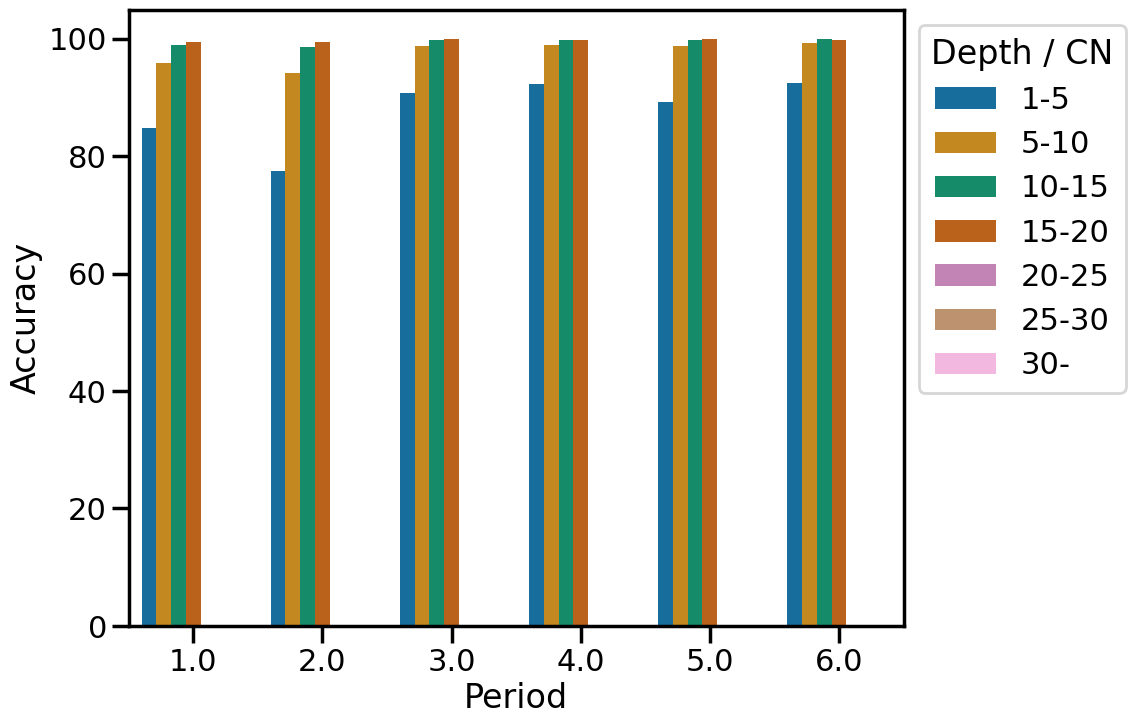

In [18]:
fig = plt.figure(figsize=(10, 8))

ax = sns.barplot(
    df_plot,
    x="period",
    y="accuracy",
    hue="depth",
    palette="colorblind"
)

ax.set(
    xlabel="Period",
    ylabel = "Accuracy"
)

_ = ax.get_legend().set(
    title="Depth / CN",
    bbox_to_anchor = (1, 1)
)

In [19]:
from scipy import ndimage

df_plot_density = (
    df_comparison
        .query("period >= 1 and period <= 6")
        .assign(depth = lambda x: x["depth"] / x["copy_number"])[["match", "period", "depth"]]
)

df_plot_smooth = (
    df_plot_density        
        .drop("period", axis=1)
        .groupby(["depth"], observed=True, as_index=False).agg(
            accuracy = ("match", lambda x: x.sum() / len(x)), 
            n_obs=("match", "count"))
        # .query(f"n_obs >= {min_obs}")
        
)

smooth = []
smooth = ndimage.gaussian_filter1d(df_plot_smooth["accuracy"], 3, mode="reflect")
df_plot_smooth = df_plot_smooth.assign(smooth = smooth)


df_plot_smooth_period = (
    df_plot_density
        .groupby(["period", "depth"], observed=True, as_index=False).agg(
            accuracy = ("match", lambda x: x.sum() / len(x)), 
            n_obs=("match", "count"))
        # .query(f"n_obs >= {min_obs}")
        
)

smooth = []
for group, data in df_plot_smooth_period.groupby(["period"]):
    current_smooth = ndimage.gaussian_filter1d(data["accuracy"], 3, mode="reflect")
    smooth.append(current_smooth)
df_plot_smooth_period = df_plot_smooth_period.assign(smooth = np.concatenate(smooth))

df_plot_smooth_period

,period,depth,accuracy,n_obs,smooth
0,1,3.0,0.811735,27116,0.856369
1,1,3.5,0.819428,25901,0.861883
2,1,4.0,0.885905,28073,0.872050
3,1,4.5,0.869678,28652,0.885406
4,1,5.0,0.912431,33151,0.900287
...,...,...,...,...,...
151,6,13.5,0.998748,799,0.999175
152,6,14.0,1.000000,677,0.999110
153,6,14.5,1.000000,402,0.999011
154,6,15.0,1.000000,430,0.998911


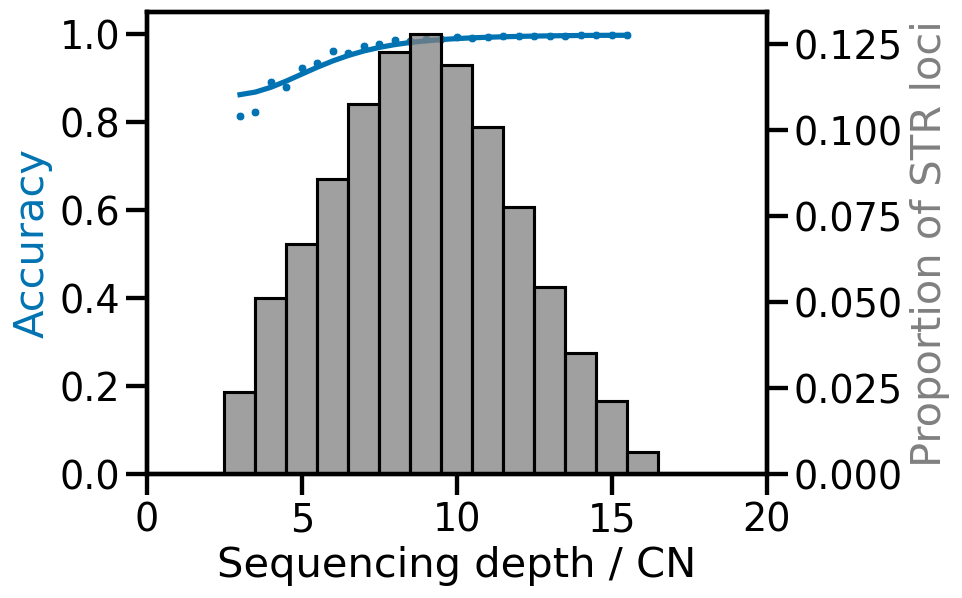

In [20]:
fig = plt.figure(dpi=125)

ax = sns.lineplot(
    df_plot_smooth.assign(tmp="ConSTRain"), # hack to add a legend
    x = "depth",
    y = "smooth",
    hue="tmp",
    palette="colorblind",
    legend=False
)

ax = sns.scatterplot(
    df_plot_smooth,
    x = "depth",
    y = "accuracy",
    color=sns.color_palette("colorblind")[0],
    s=25,
    ax = ax,
)

ax.set(
    xlabel = "Sequencing depth / CN",
    ylabel = "Accuracy",
    ylim = (0, 1.05),
    xlim = (0, 20)
)
ax.yaxis.label.set_color(color=sns.color_palette("colorblind")[0])

ax2 = ax.twinx()
ax2 = sns.histplot(
    df_plot_density,
    x = "depth",
    discrete=True,
    stat="proportion",
    color="grey",
    ax=ax2,
)
ax2.set(
    ylabel="Proportion of STR loci",
    # ylim=(0, 0.07),
)
ax2.yaxis.label.set_color(color="grey")

plt.show()

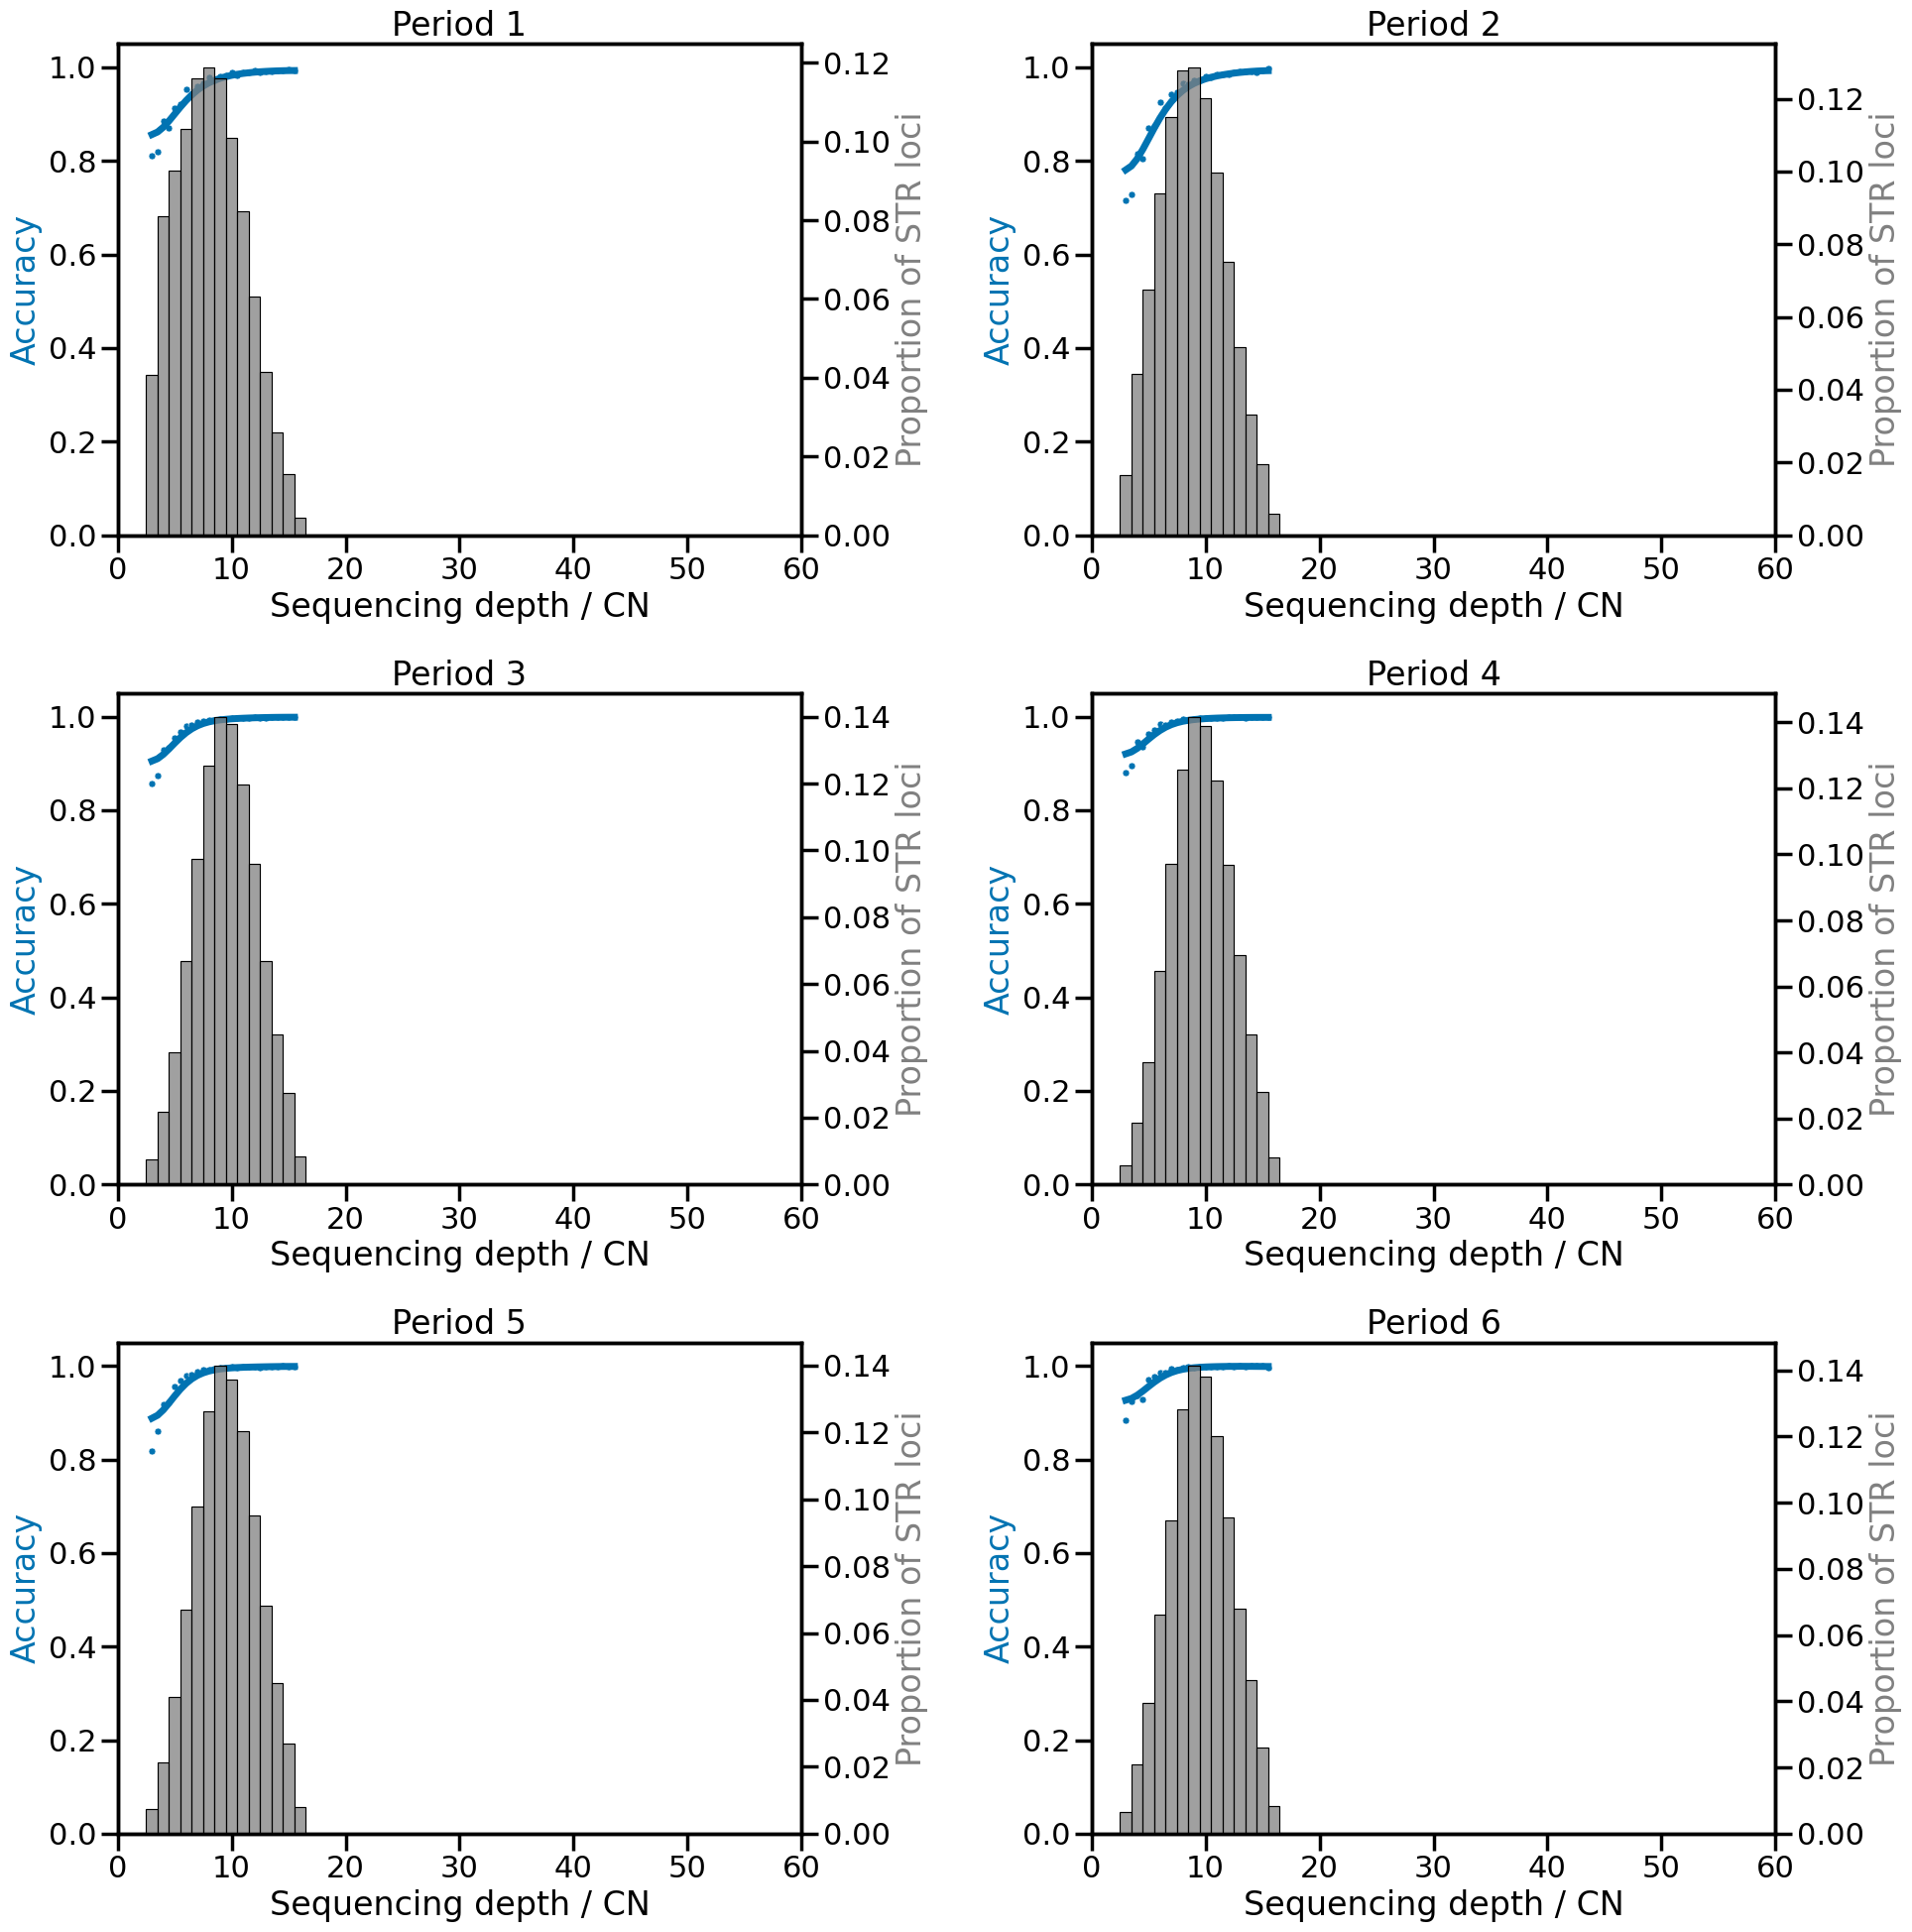

In [22]:
fig, axes = plt.subplots(3, 2, figsize=(20, 20))

for period, ax in zip(range(1, 7), axes.ravel()):
    df_subplot = (df_plot_smooth_period
                  .query(f"period == {period}"))

    ax = sns.lineplot(
        df_subplot,
        x = "depth",
        y = "smooth",
        color=sns.color_palette("colorblind")[0],
        linewidth=5,
        ax = ax,
    )

    ax = sns.scatterplot(
        df_subplot,
        x = "depth",
        y = "accuracy",
        color=sns.color_palette("colorblind")[0],
        s=25,
        ax = ax,
    )

    ax.set(
        title = f"Period {period}",
        xlabel = "Sequencing depth / CN",
        ylabel = "Accuracy",
        ylim = (0, 1.05),
        xlim = (0, 60)
    )
    ax.yaxis.label.set_color(color=sns.color_palette("colorblind")[0])
    
    ax2 = ax.twinx()
    ax2 = sns.histplot(
        df_plot_density.query(f"period == {period}"),
        x = "depth",
        discrete=True,
        stat="proportion",
        color="grey",
        ax=ax2,
    )
    
    ax2.set(
        ylabel="Proportion of STR loci",
        # ylim=(0, 0.08),
    )
    ax2.yaxis.label.set_color(color="grey")

plt.tight_layout()